## Multimodal agent

### 1. Research Agent
Create an agent that performs research using the TavilySearch tool. This agent is used to gather the required information

### 2. Chart Generator Agent
Create an agent that generates charts using the PythonREPL tool. This agent is used to create charts.

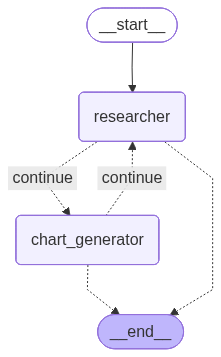

In [9]:
import os
import operator
import uuid
from typing import Annotated, Sequence
from typing_extensions import TypedDict
import matplotlib
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_experimental.utilities import PythonREPL

from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

class MessagesState(TypedDict):
    messages: Sequence[BaseMessage]

load_dotenv(override=True)

# Python REPL tool
python_repl = PythonREPL()

# Tavily Search Tool
tavily_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    tavily_api_key=os.getenv("TAVILY_API_KEY")
)

# Defining the Python REPL tool
@tool
def python_repl_tool(code: Annotated[str, "Pure Python code only. You MUST save charts as image files"]):
    """
    Execute Python code. Charts MUST be saved to disk and file path printed.
    """
    try:
        result = python_repl.run(code)
    except BaseException as e: 
        return f"Execution failed: {repr(e)}"
    return f"Python executed successfully.\n{result}"

llm = ChatOpenAI(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0
)

# System Prompt Helper
def make_system_prompt(suffix: str) -> str:
    return (
        "You are part of a multi-agent system.\n"
        "Follow your role strictly.\n"
        "Do not refuse tasks.\n"
        "Do not explain limitations.\n"
        f"{suffix}"
    )

# Research agent system prompt
research_agent_system_prompt = """
You are a research agent.

Your job is to gather data needed for chart generation.

STRICT RULES:
1. Use tools like TavilySearch when extrenal data is required.
2. ALWAYS extract or infer numeric values.
3. NEVER refuse due to lack of real-time access.
4. If exact values are unavailable, use best estimates.
5. DO NOT generate charts or code.

OUTPUT FORMAT (MANDATORY):
Return data in a simple, structured, machine-readable format.

Example:
Label: <category or x-axis value>
Value: <numeric value>
Unit: <optional>

Repeat for each data point.
""" 

# Binding LLMs and Tools for research agent using create_react_agent()
research_agent = create_agent(
    llm,
    tools=[tavily_tool],
    system_prompt=make_system_prompt(research_agent_system_prompt)
)

def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)
    return {'messages': result["messages"]}

chart_generator_system_prompt = """
You are a chart-generation agent.

STRICT RULES (ABSOLUTE):
1. You MUST extract numeric values from prior messages.
2. You MUST choose an appropriate chart type.
3. You MUST call python_repl_tool EXACTLY ONCE.
4. ALL Python code MUST be inside python_repl_tool.
5. You MUST save the chart as a PNG file.
6. You MUST print the saved file path.
7. You MUST NOT write Python code outside the tool call.
8. You MUST NOT speak or explain before the tool call.
9. After the tool executes, respond ONLY with:
FINAL ANSWER
"""

chart_agent = create_agent(
    llm,
    tools=[python_repl_tool],
    system_prompt=make_system_prompt(chart_generator_system_prompt),
)


def chart_node(state: MessagesState):
    result = chart_agent.invoke(state)
    return {"messages": result["messages"]}

# Defining Router function
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

# Build Graph
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)
workflow.add_edge(START, "researcher")

app = workflow.compile(checkpointer=MemorySaver())

app

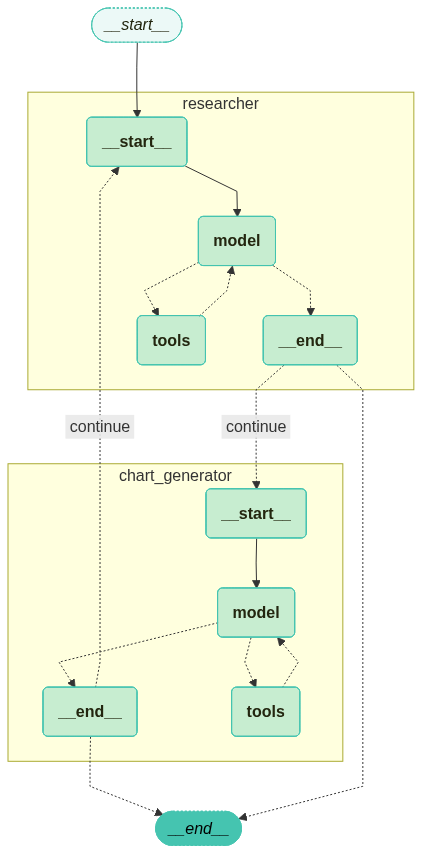

In [10]:
from langchain_opentutorial.graphs import visualize_graph
visualize_graph(app, xray=True)

Python REPL can execute arbitrary code. Use with caution.


{'messages': [HumanMessage(content='Can you give me a bar chart for GDPs of India, USA and China for the year 2024', additional_kwargs={}, response_metadata={}, id='0d329fbe-52e6-418a-a6a9-72ba390aab7f'),
  AIMessage(content="To provide a bar chart for GDPs of India, USA, and China for the year 2024, I need to gather the GDP data for these countries for that year. Since I don't have real-time access to future data, I'll use the most recent available projections.\n\nI'll start by searching for the projected GDP values for India, USA, and China for 2024.\n\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 914, 'total_tokens': 1031, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.054734001, 'prompt_time': 0.024179399, 'completion_time': 0.281398849, 'total_time': 0.305578248}, 'model_provider': 'openai', 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp

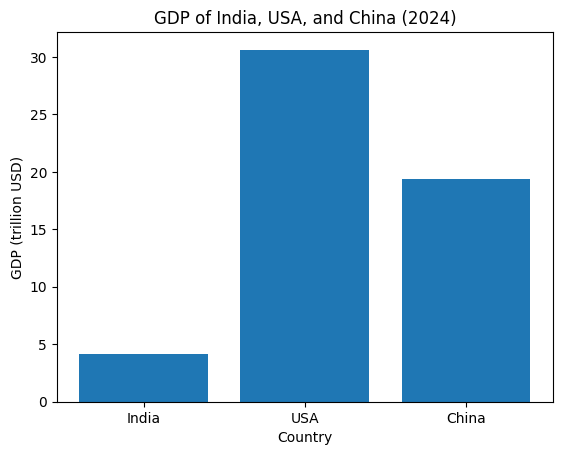

In [11]:
# Invoke Graph
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": str(uuid.uuid4())}
)
inputs = {
    "messages": [
        HumanMessage(
            content="Can you give me a bar chart for GDPs of India, USA and China for the year 2024"
        )
    ]
}

result = app.invoke(inputs, config=config)

result